# ARIMA model for BTC forecasting

## Libraries


Pandas, Numpy, statsmodel and matplotlib libraries are imported.

In [ ]:
import pandas as pd
import pandas as df
import pandas as pnd
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from scipy import stats
from matplotlib.dates import DateFormatter
import pmdarima as pm


## Data Exploration - BTC/USD 


Plots are generated for the total data as well as for the selected data set.

--------------- Original Dataset ---------------
                           unix   symbol      open      high       low  \
date                                                                     
2022-11-18 00:00:00  1668729600  BTC/USD  16687.00  16912.00  16680.00   
2022-11-17 23:00:00  1668726000  BTC/USD  16704.00  16714.00  16651.00   
2022-11-17 22:00:00  1668722400  BTC/USD  16683.00  16714.00  16666.00   
2022-11-17 21:00:00  1668718800  BTC/USD  16680.00  16724.00  16680.00   
2022-11-17 20:00:00  1668715200  BTC/USD  16603.00  16682.00  16597.00   
...                         ...      ...       ...       ...       ...   
2018-05-15 10:00:00  1526378400  BTC/USD   8708.32   8865.00   8695.11   
2018-05-15 09:00:00  1526374800  BTC/USD   8728.49   8754.40   8701.35   
2018-05-15 08:00:00  1526371200  BTC/USD   8739.00   8750.27   8660.53   
2018-05-15 07:00:00  1526367600  BTC/USD   8740.99   8766.00   8721.11   
2018-05-15 06:00:00  1526364000  BTC/USD   8733.86   8796.68   

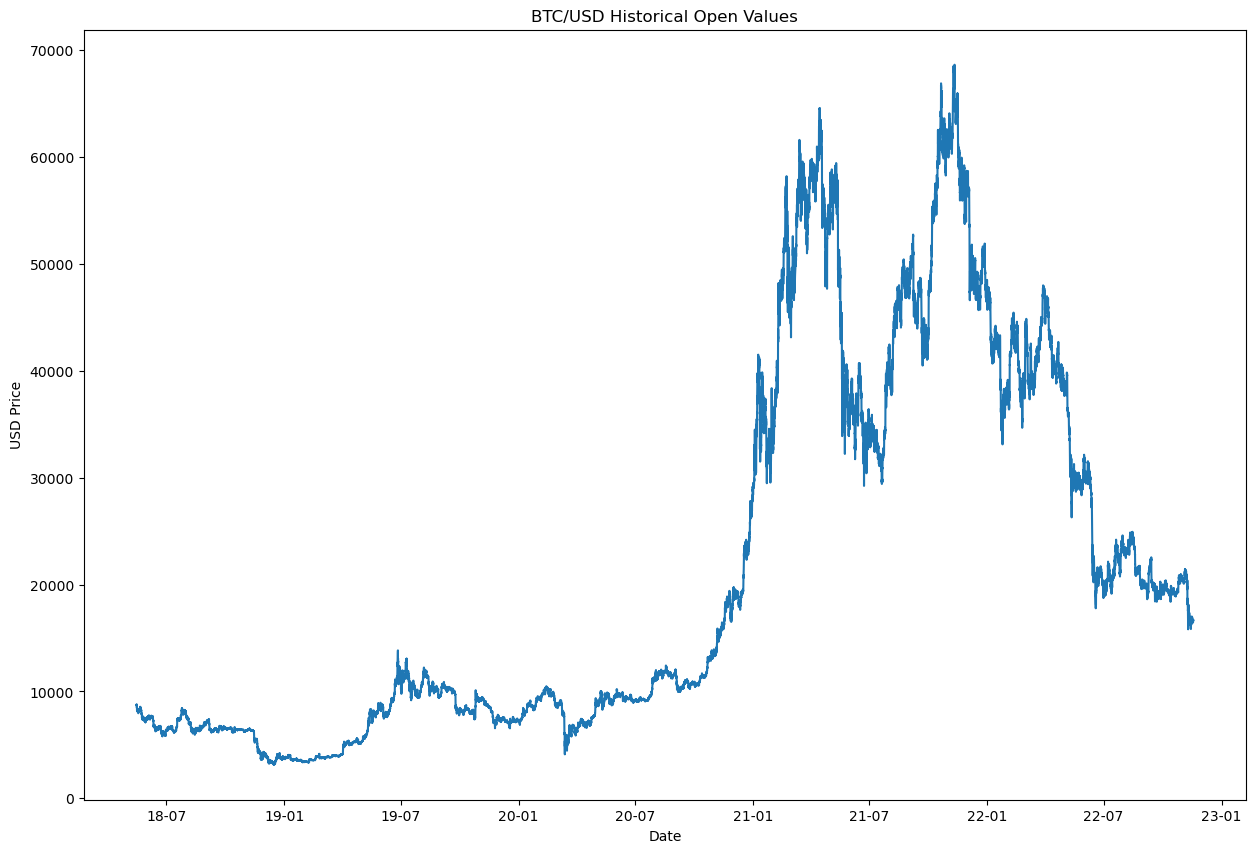



--------------- Selected Open values (Pandemic times) ---------------
                         open
date                         
2022-11-18 00:00:00  16687.00
2022-11-17 23:00:00  16704.00
2022-11-17 22:00:00  16683.00
2022-11-17 21:00:00  16680.00
2022-11-17 20:00:00  16603.00
...                       ...
2020-10-29 05:00:00  13252.08
2020-10-29 04:00:00  13276.91
2020-10-29 03:00:00  13250.42
2020-10-29 02:00:00  13287.32
2020-10-29 01:00:00  13261.17

[18000 rows x 1 columns]
Total samples BTC/USD: 18000


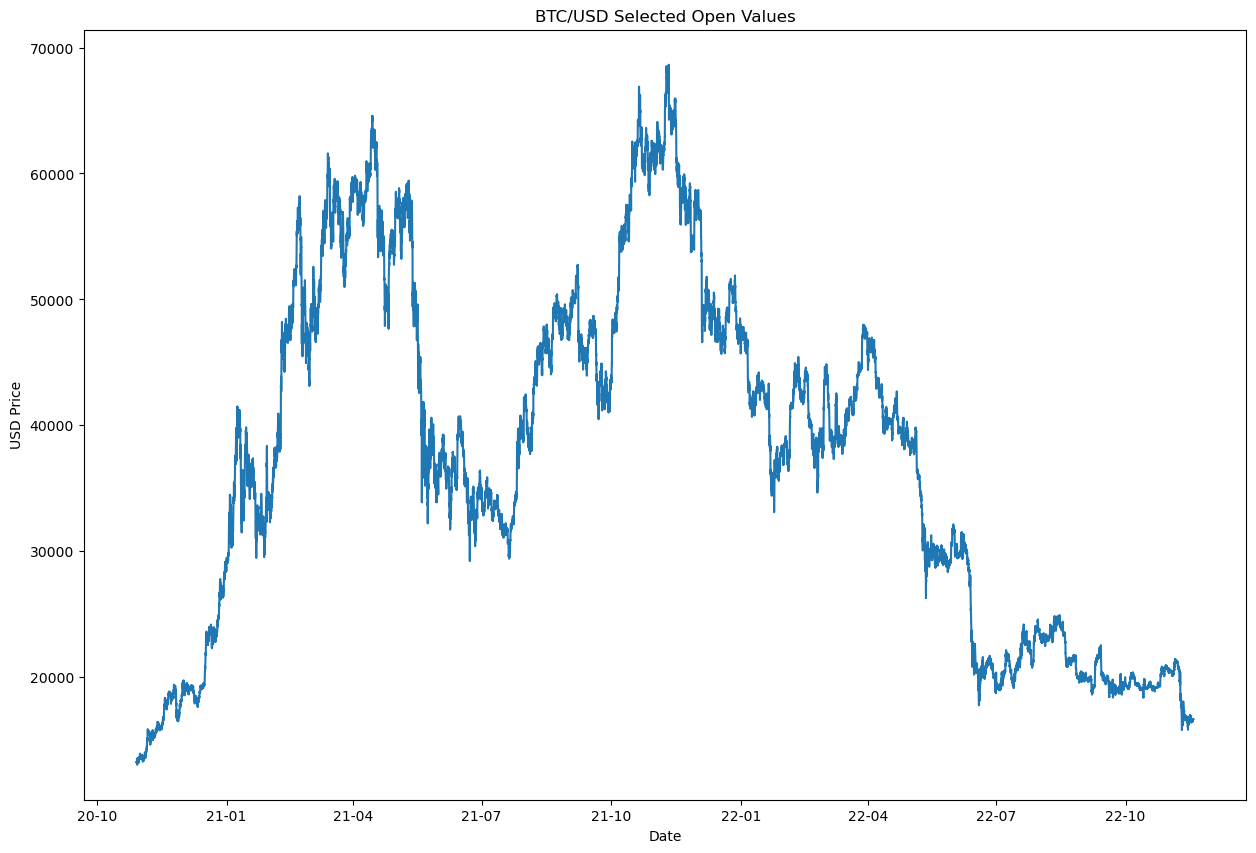

In [ ]:
date_form = DateFormatter("%y-%m")
btc = pnd.read_csv('Bitstamp_BTCUSD_1h.csv', sep=',', header=1, index_col=1, parse_dates=True)

print("--------------- Original Dataset ---------------")
print(btc)
print(f"Total samples BTC/USD: {len(btc)}")
print(btc.shape)

btc_open = pd.DataFrame(btc, columns=["open"])
samples_number = 18000

fig, ax = plt.subplots()
plt.plot(btc_open)
plt.title('BTC/USD Historical Open Values')
ax.xaxis.set_major_formatter(date_form)
plt.ylabel('USD Price')
plt.xlabel('Date')
plt.show()

print("")
print("")
print("--------------- Selected Open values (Pandemic times) ---------------")

btc_open = btc_open.iloc[0:samples_number]

print(btc_open)
print(f"Total samples BTC/USD: {len(btc_open)}")

fig, ax = plt.subplots()
plt.plot(btc_open)
plt.title('BTC/USD Selected Open Values')
ax.xaxis.set_major_formatter(date_form)
plt.ylabel('USD Price')
plt.xlabel('Date')
plt.show()



Graphs are made by month, by three months, by two weeks and daily. 

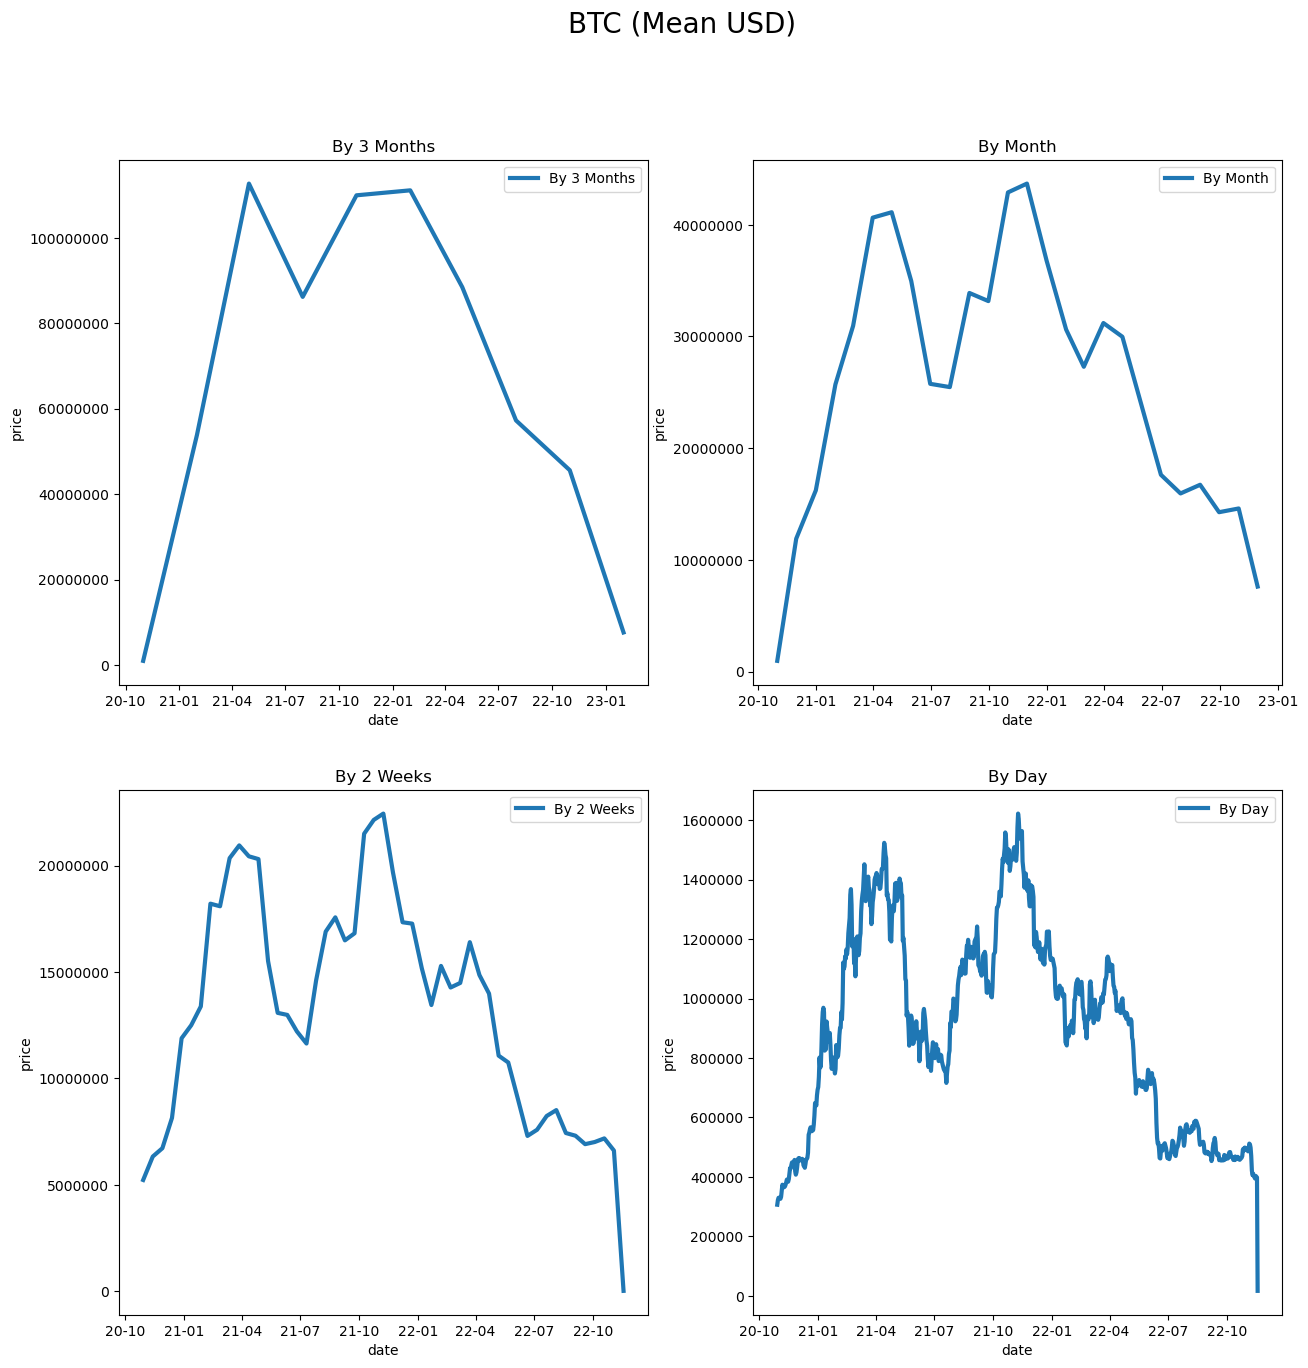

In [ ]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,15)

fig.suptitle('BTC (Mean USD)', fontsize=20)
ax[0,0].plot(btc_open.resample('3M').sum(),'-', label='By 3 Months', linewidth = 3)
ax[0,1].plot(btc_open.resample('1M').sum(),'-', label='By Month', linewidth = 3)
ax[1,0].plot(btc_open.resample('15D').sum(),'-', label='By 2 Weeks', linewidth = 3)
ax[1,1].plot(btc_open.resample('1D').sum(),'-', label='By Day', linewidth = 3)
ax[0,0].legend()
ax[0,1].legend()
ax[1,1].legend()
ax[1,0].legend()

ax[0,0].set_title('By 3 Months')
ax[0,0].xaxis.set_major_formatter(date_form)
ax[0,0].set_xlabel('date')
ax[0,0].set_ylabel('price')
ax[0,0].ticklabel_format(style='plain', axis='y', useMathText=False)

ax[0,1].set_title('By Month')
ax[0,1].xaxis.set_major_formatter(date_form)
ax[0,1].set_xlabel('date')
ax[0,1].set_ylabel('price')
ax[0,1].ticklabel_format(style='plain', axis='y', useMathText=False)

ax[1,0].set_title('By 2 Weeks')
ax[1,0].xaxis.set_major_formatter(date_form)
ax[1,0].set_xlabel('date')
ax[1,0].set_ylabel('price')
ax[1,0].ticklabel_format(style='plain', axis='y', useMathText=False)


ax[1,1].set_title('By Day')
ax[1,1].xaxis.set_major_formatter(date_form)
ax[1,1].set_xlabel('date')
ax[1,1].set_ylabel('price')
ax[1,1].ticklabel_format(style='plain', axis='y', useMathText=False)

Based on this, it is decided that the daily signal will be predicted.

## Data Pre-Processing

### Stationarity check and STL-decomposition of the series

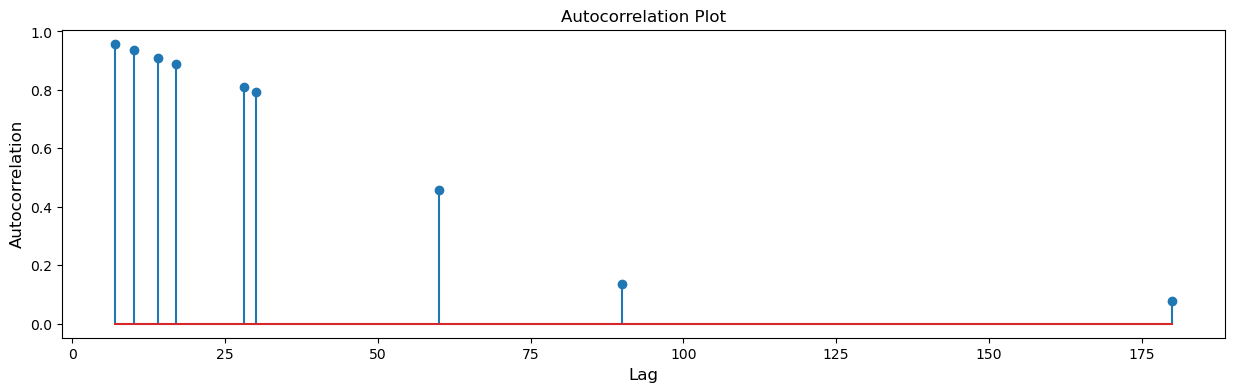

In [ ]:
btc_open_day = btc_open.resample('1D').sum()

lags = [7, 10, 14, 17, 28, 30, 60, 90, 180] 
autocorrs = [btc_open_day.open.autocorr(lag=lag) for lag in lags]
plt.figure(figsize=(15, 4))
plt.stem(lags, autocorrs)
plt.title("Autocorrelation Plot")
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.show()

According to the chart above, the highest correlation occurs with a lag of 7, meaning that the data repeats a pattern on a weekly basis. This is somewhat true for the Bitcoin price, as from experience it has been seen that the price tends to have a similar behavior every week due to the periodicity of the markets and the actions of those involved. 


Another way of checking the autocorrelation is through Pandas tools library. Running that we can see positive correlation for the first 100 lags with the most significant ones being the first 10 ones.



--------------- Autocorrelation Plot---------------


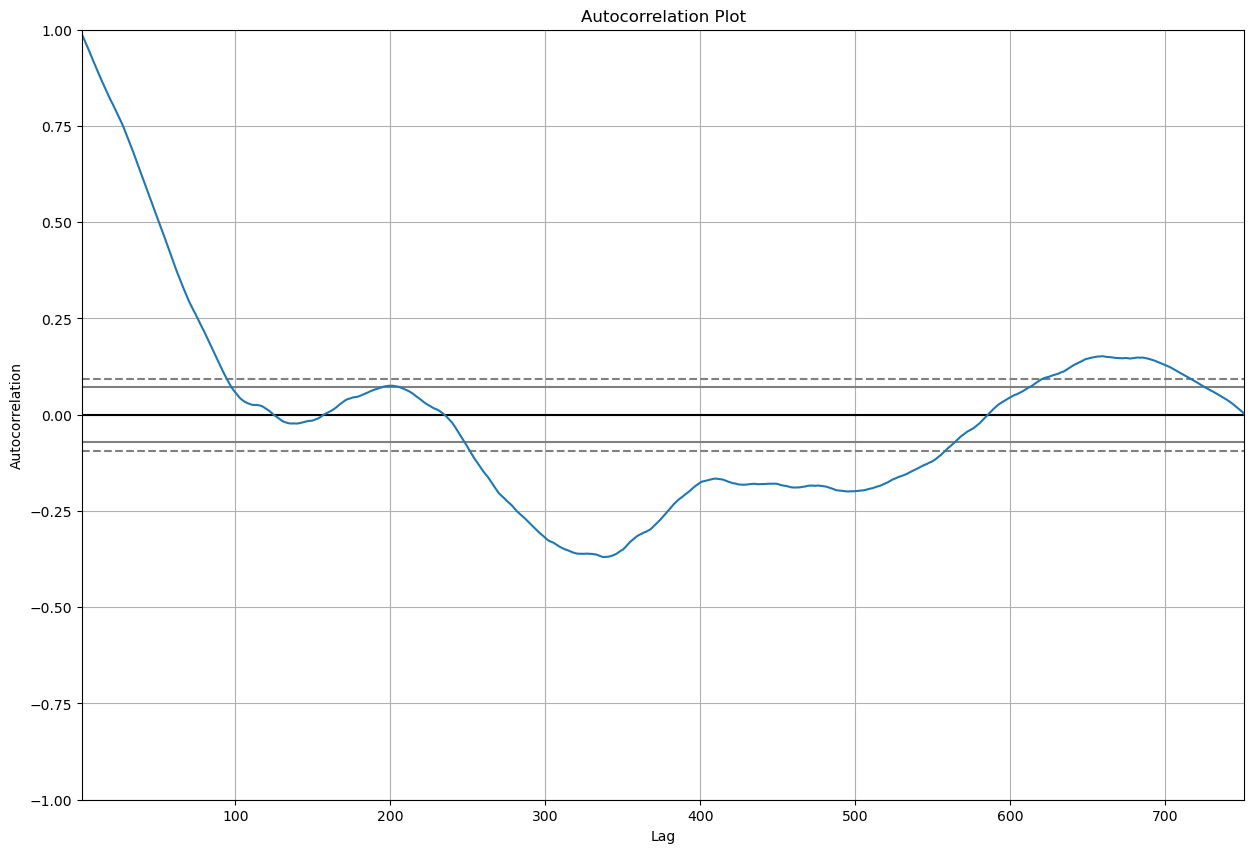

In [ ]:
from pandas.plotting import autocorrelation_plot
print("")
print("")
print("--------------- Autocorrelation Plot---------------")

autocorrelation_plot(btc_open_day)
plt.title("Autocorrelation Plot")
plt.show()


Using Seasonal decompose

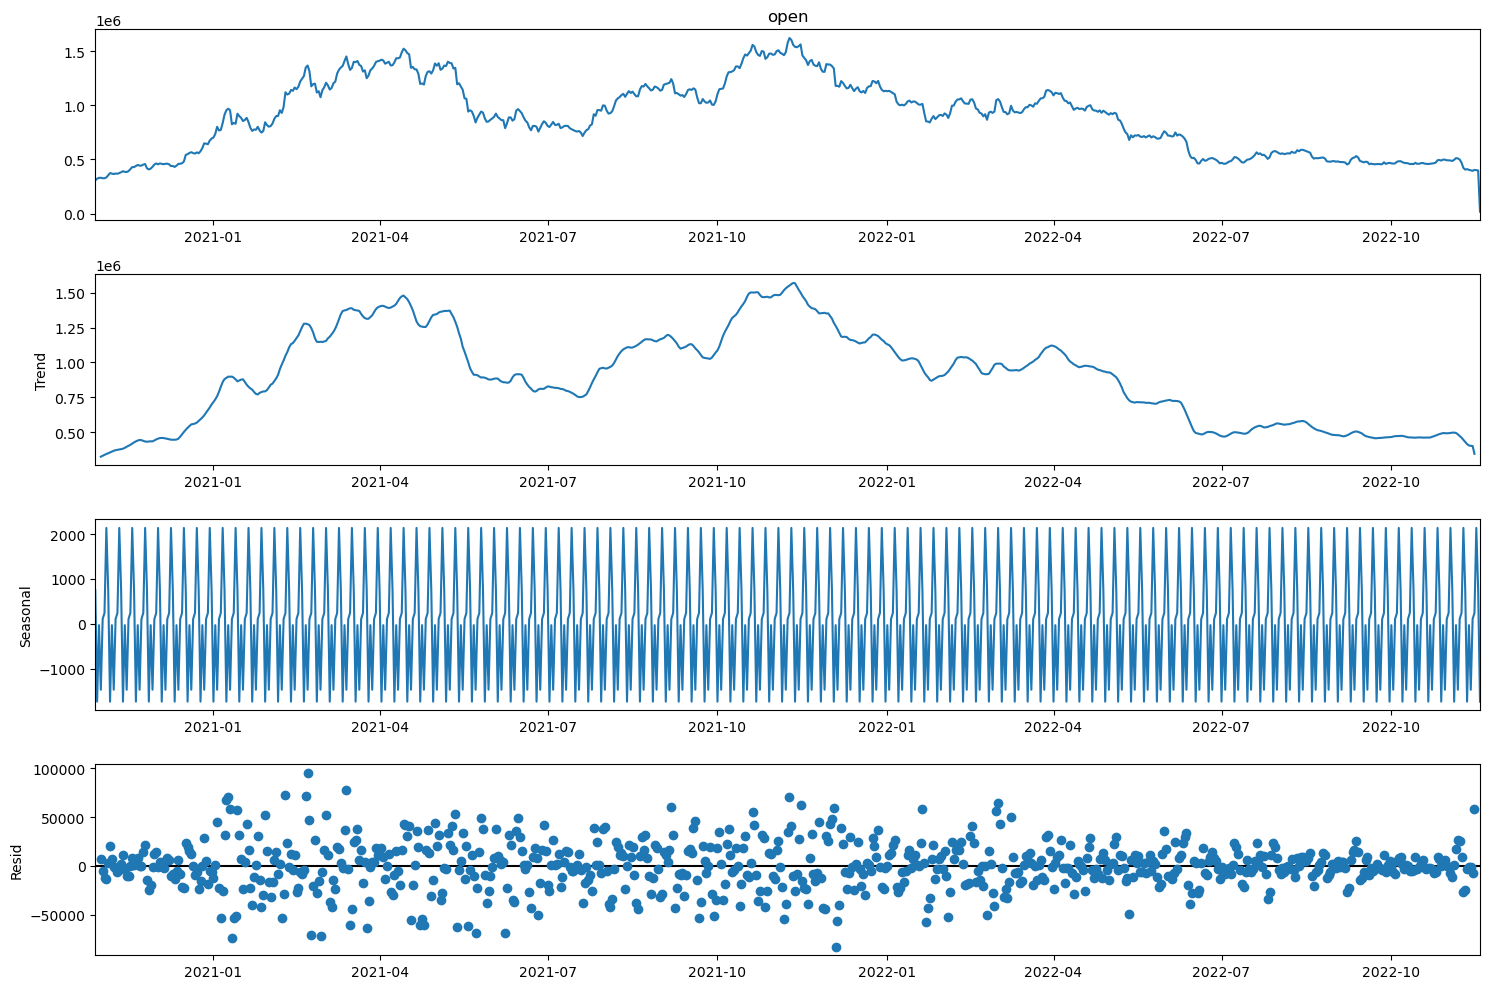

--------------- Dickey–Fuller test ---------------
p=0.797914


In [ ]:
sm.tsa.seasonal_decompose(btc_open_day.open).plot()
plt.rcParams["figure.figsize"] = (15,13)
plt.show()
print("--------------- Dickey–Fuller test ---------------")
print("p=%f" % sm.tsa.stattools.adfuller(btc_open_day.open)[1])



The series are not stationary based on the results of the Dickey-Fuller test.

### Box Cox Transformation


A Box Cox transformation is a transformation of non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests.

In [ ]:
btc_open_day_bc = btc_open_day['open']
btc_open_day_bc['open'], lmbda = stats.boxcox(btc_open_day.open)
print("--------------- Dickey–Fuller test ---------------")
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_open_day_bc.open)[1])


--------------- Dickey–Fuller test ---------------
Dickey–Fuller test: p=0.927766


Series are not stationary

### Seasonal Differentiation

In [ ]:
# Seasonal differentiation
btc_open_day_sd = btc_open_day
btc_open_day_sd['open'] = btc_open_day_bc - btc_open_day_bc.shift(7)
print("--------------- Dickey–Fuller test ---------------")
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_open_day_sd.open[7:])[1])

--------------- Dickey–Fuller test ---------------
Dickey–Fuller test: p=0.000014


Series are now stationary

### Seasonal decompose

<Figure size 16000x3000 with 0 Axes>

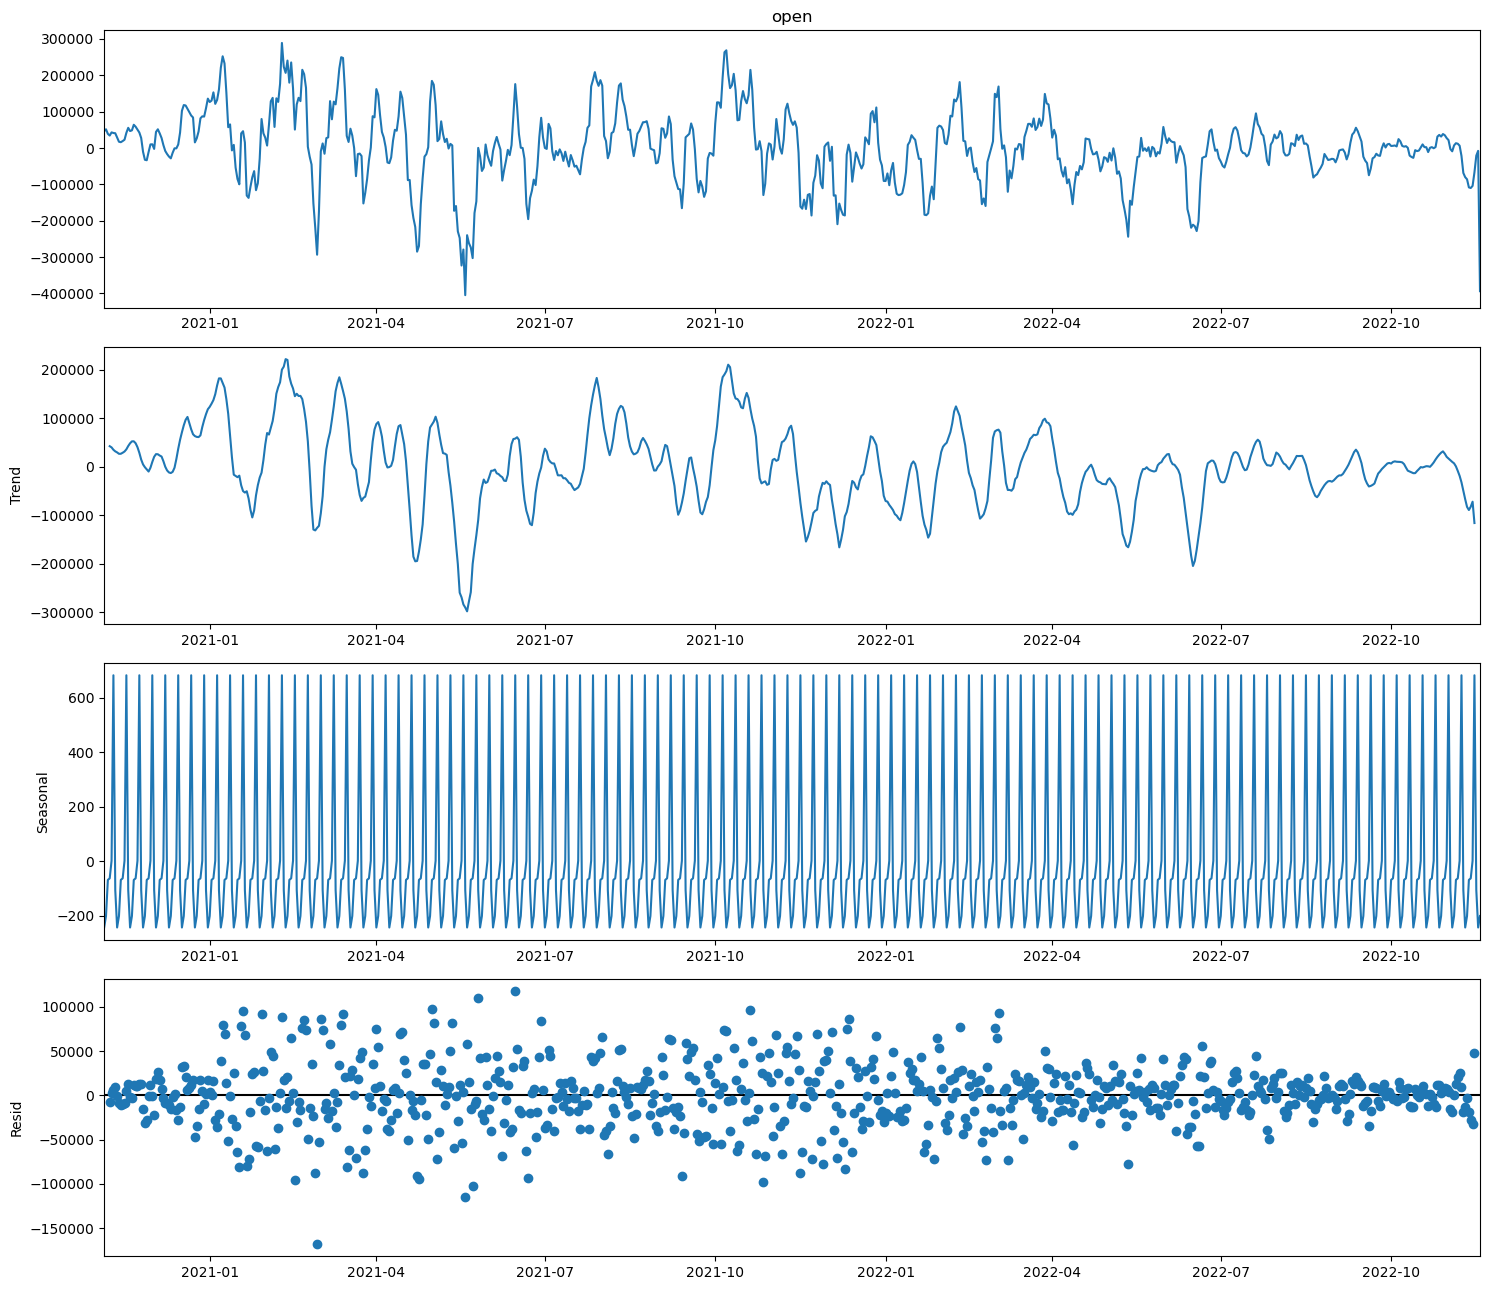

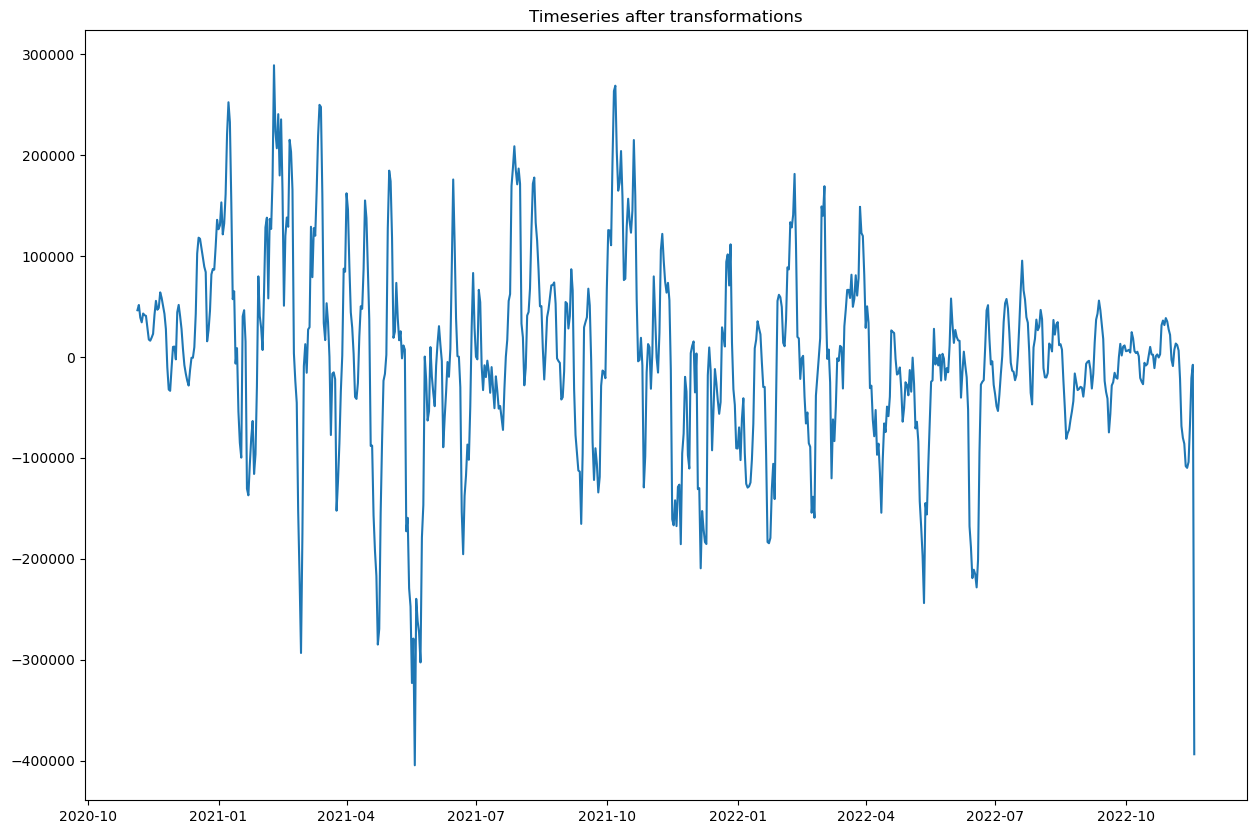

In [ ]:
plt.figure(figsize=(160,30))
sm.tsa.seasonal_decompose(btc_open_day_sd.open[7:]).plot()
plt.rcParams["figure.figsize"] = (15,10)
plt.show()
plt.figure()
plt.title("Timeseries after transformations")
plt.plot(btc_open_day_sd)

### Split training and validation set

the data set will be divided where 90% of the data was used for training and 10% will be used for validation.

In [ ]:
btc_open_day_sd = btc_open_day_sd.dropna()
size = int(len(btc_open_day_sd) * 0.90)
X = btc_open_day_sd
train, test = X[0:size], X[size:len(X)]


print("")
print("")
print("--------------- Train Set ---------------")
print(train)
print("")
print("")
print("--------------- Validation Set ---------------")
print(test)





--------------- Train Set ---------------
                open
date                
2020-11-05  46317.56
2020-11-06   51544.1
2020-11-07  39080.79
2020-11-08  34326.08
2020-11-09  43068.37
...              ...
2022-08-31  -30363.0
2022-09-01  -39290.0
2022-09-02  -26602.0
2022-09-03   -6761.0
2022-09-04   -4764.0

[669 rows x 1 columns]


--------------- Validation Set ---------------
                open
date                
2022-09-05   -3800.0
2022-09-06  -12434.0
2022-09-07  -31272.0
2022-09-08  -16763.0
2022-09-09   14265.0
...              ...
2022-11-14 -104053.0
2022-11-15  -66958.0
2022-11-16  -20901.0
2022-11-17   -7754.0
2022-11-18 -393769.0

[75 rows x 1 columns]


## AUTO_ARIMA Parameter Tunning



The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model. This process is based on the commonly-used R function, forecast::auto.arima.

Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In order to find the best model, auto-ARIMA optimizes for a given information_criterion, one of (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’) (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively) and returns the ARIMA which minimizes the value.

In [ ]:

# Fit models

model_fit = pm.auto_arima(train, start_p = 1, max_p = 8, start_q = 1, max_q = 8, 
                          max_d = 8, n_fits = 5, start_P = 0, 
                          start_Q = 0, max_P = 8, max_Q = 8, max_D = 8, 
                          trace=True, random = True)


print("")
print("")
print("--------------- Model Summary ---------------")

print(model_fit.summary())





Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16239.334, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16252.323, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16237.832, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16237.427, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16250.325, Time=0.01 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16239.220, Time=0.07 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16214.980, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=16234.757, Time=0.09 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=16212.980, Time=0.18 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=16237.221, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16237.335, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16235.429, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=16232.758, Time=0.08 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.61 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.766 seconds


--------------- Model Summary ---------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  669
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -8102.490
Date:                Sun, 29 Jan 2023   AIC                          16212.980
Time:                        13:24:13   BIC                          16230.998
Sample:                    11-05-2020   HQIC                         16219.960
                         - 09-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

## ARIMA Training and Prediction

taking into account the results obtained for the optimal parameters, these parameters will be used to make the prediction and evaluation of the final model.  Best model:  ARIMA(1,1,2)

In [ ]:

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


#print(train.values)
history = [x for x in train.values.astype(float)] #[x for x in train.values]
testList = test.values.astype(float)
predictions = list()
for t in range(len(testList)):
 model = ARIMA(history, order=(7,2,14)) #Based on the results of auto_arima lib
 model_fit = model.fit()
 output = model_fit.forecast()
 predictions.append(output[0])
 obs = testList[t]
 history.append(obs)
 print("Prediction # : " + str(t))



/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Prediction # : 0
Prediction # : 1
Prediction # : 2
Prediction # : 3
Prediction # : 4
Prediction # : 5
Prediction # : 6
Prediction # : 7
Prediction # : 8
Prediction # : 9
Prediction # : 10
Prediction # : 11
Prediction # : 12
Prediction # : 13
Prediction # : 14
Prediction # : 15
Prediction # : 16
Prediction # : 17
Prediction # : 18
Prediction # : 19
Prediction # : 20
Prediction # : 21
Prediction # : 22
Prediction # : 23
Prediction # : 24
Prediction # : 25
Prediction # : 26
Prediction # : 27
Prediction # : 28
Prediction # : 29
Prediction # : 30
Prediction # : 31
Prediction # : 32
Prediction # : 33
Prediction # : 34
Prediction # : 35
Prediction # : 36
Prediction # : 37
Prediction # : 38
Prediction # : 39
Prediction # : 40
Prediction # : 41
Prediction # : 42
Prediction # : 43
Prediction # : 44
Prediction # : 45
Prediction # : 46
Prediction # : 47
Prediction # : 48
Prediction # : 49
Prediction # : 50
Prediction # : 51
Prediction # : 52
Prediction # : 53
Prediction # : 54
Prediction # : 55
Pr

## Model Summary

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  743
Model:                ARIMA(7, 2, 14)   Log Likelihood               -8720.296
Date:                Sun, 29 Jan 2023   AIC                          17484.593
Time:                        13:29:58   BIC                          17585.969
Sample:                             0   HQIC                         17523.677
                                - 743                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9102      1.478     -0.616      0.538      -3.807       1.986
ar.L2         -0.6319      2.512     -0.252      0.801      -5.556       4.292
ar.L3         -0.3949      2.869     -0.138      0.8

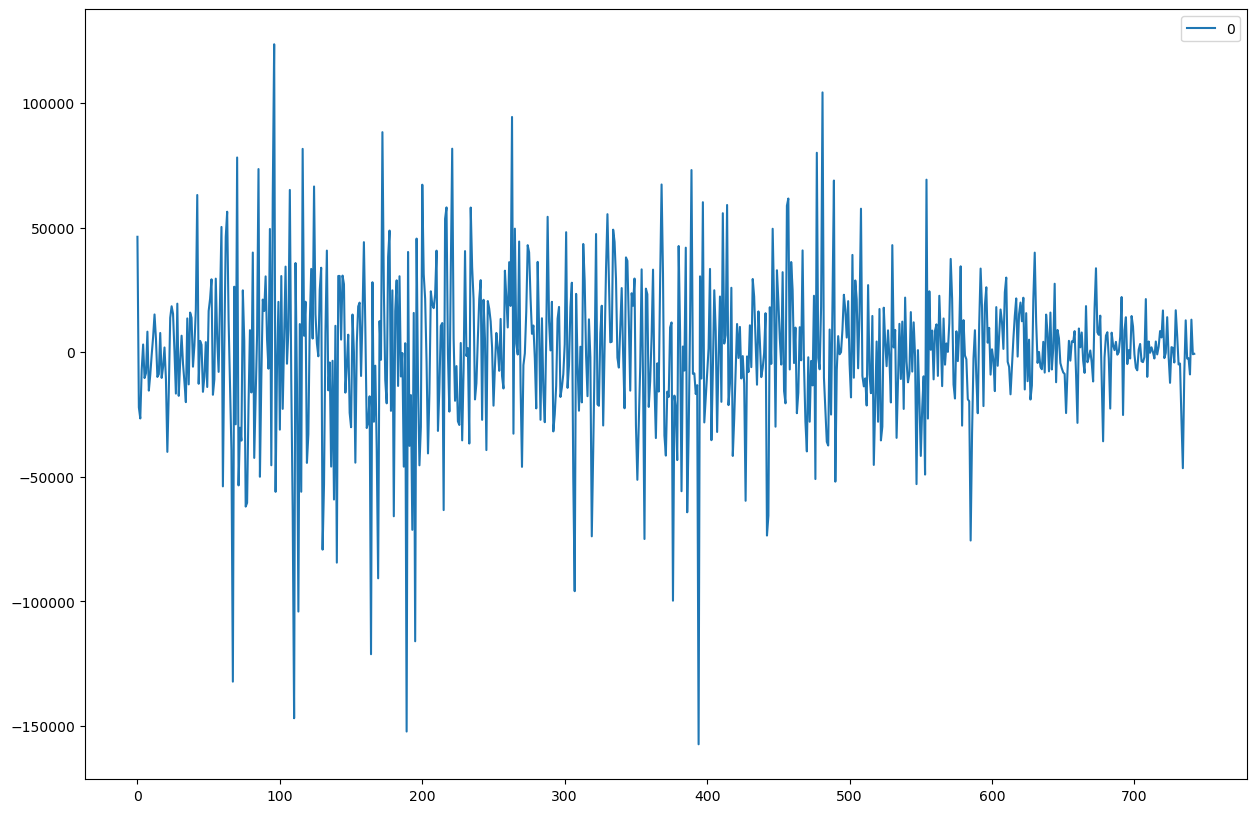



--------------- Residual Density ---------------


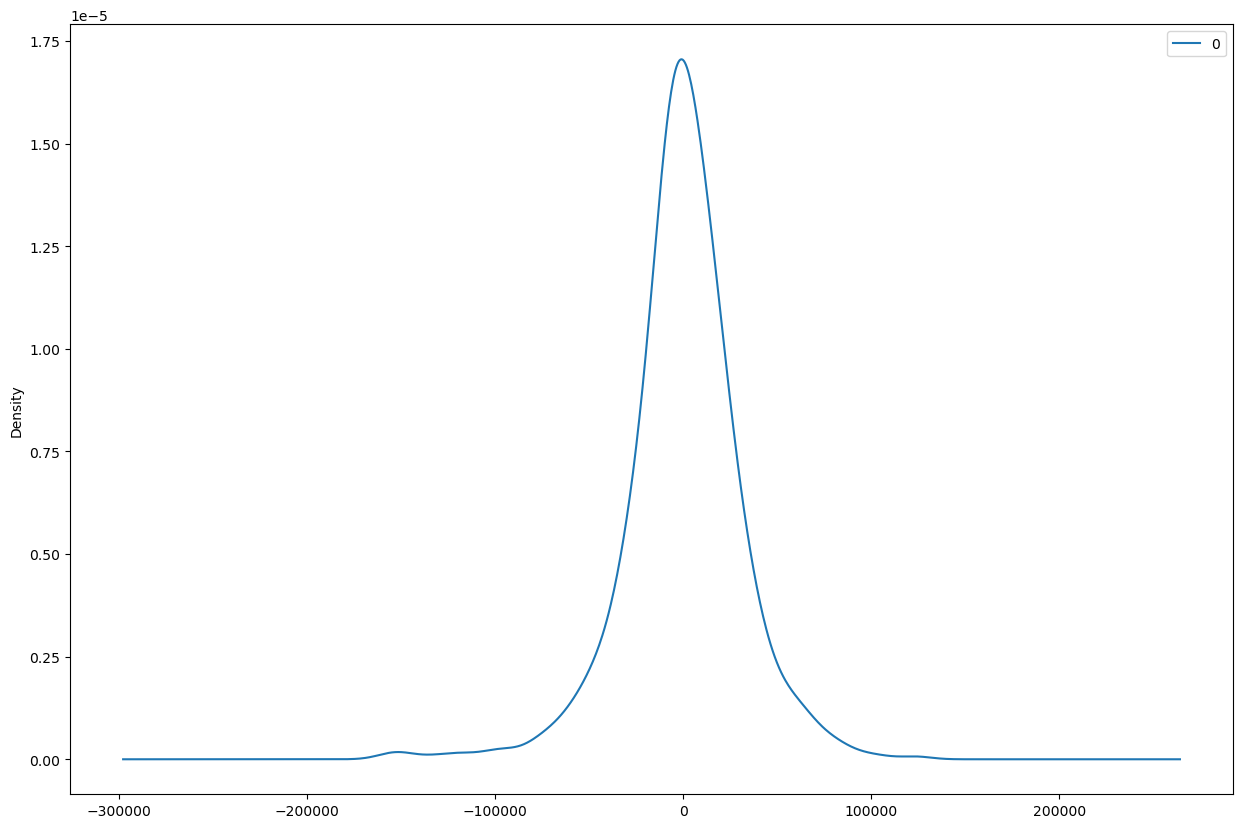



--------------- Residuals Summary ---------------
                   0
count     743.000000
mean     -110.537525
std     30686.630278
min   -157398.647200
25%    -13557.962351
50%         1.497347
75%     16414.558328
max    123596.733190


In [ ]:
print(model_fit.summary())
 
 # Residuals plot
print("")
print("")
print("--------------- Residuals Plot ---------------")
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

# density plot of residuals
print("")
print("")
print("--------------- Residual Density ---------------")
residuals.plot(kind='kde')
pyplot.show()

# summary stats of residuals
print("")
print("")
print("--------------- Residuals Summary ---------------")
print(residuals.describe())


## Performance Evaluation

{'corr': array([[1.        , 0.61306441],
       [0.61306441, 1.        ]]),
 'mae': 13418.638515873194,
 'mape': 1.6954743407805914,
 'mpe': 0.8920078920665457,
 'rmse': 44898.024935447225}


Text(0.5, 0, 'Date')

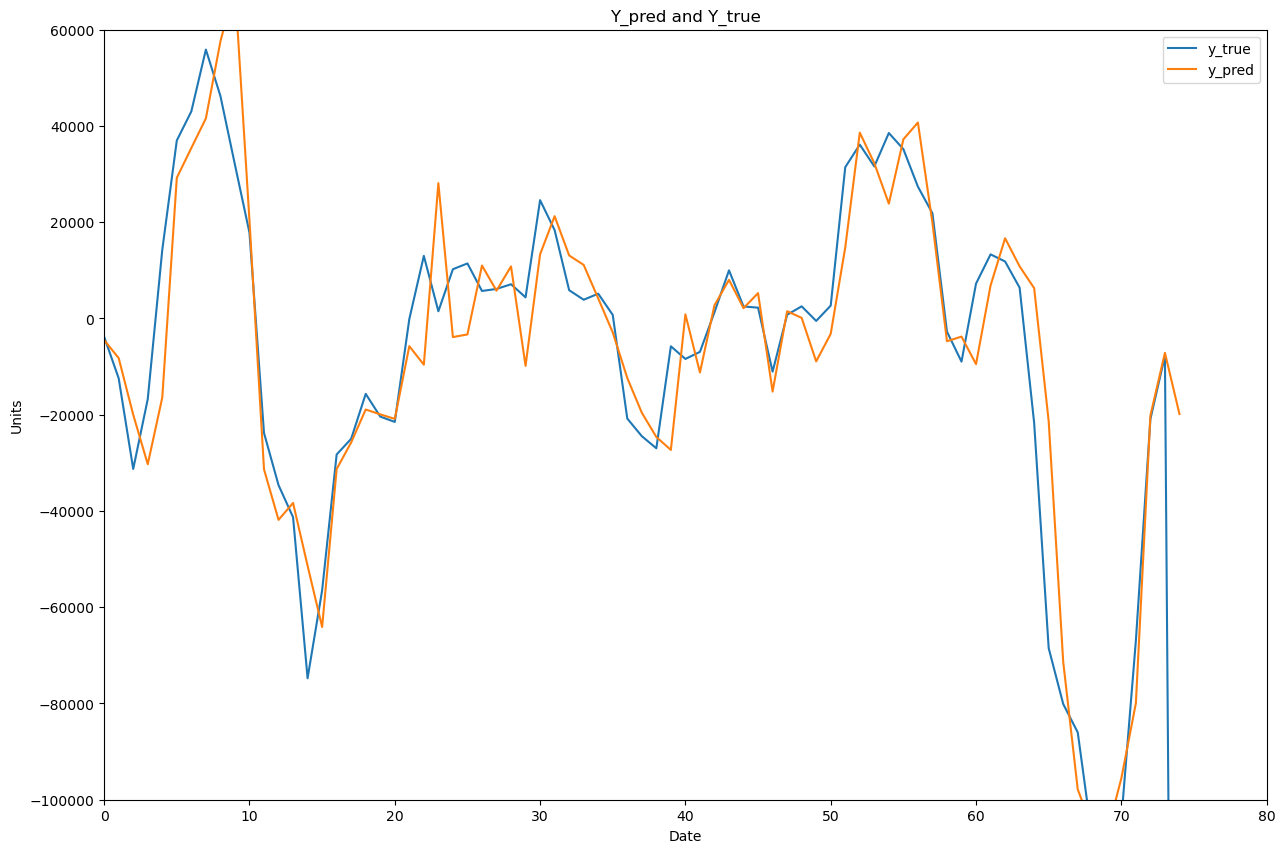

In [ ]:
import pprint

y_pred = np.array(predictions)
y_true = np.array(test.open.values.astype(float))

# Mean absolute percentage error
mape = np.mean (np.abs (y_pred - y_true)/np.abs (y_true)) 
# Mean absolute error
mae = np.mean(np.abs (y_pred - y_true))
# Mean percentage error
mpe = np.mean( (y_pred - y_true)/y_true)
# RMSE
rmse = np.mean ( (y_pred - y_true)**2)**.5 
# Correlation Coefficient
corr = np.corrcoef(y_pred, y_true)


pprint.pprint({'mape' :mape, 
                'mae': mae,
                'mpe' : mpe,
                'rmse' :rmse,
                'corr': corr})

plt.figure()
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.axis([0, 80, -100000, 60000])
plt.title('Y_pred and Y_true')
plt.legend()
plt.ylabel('Units')
plt.xlabel('Date')





## References



https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

OTher reference https://www.projectpro.io/article/how-to-build-arima-model-in-python/544

Docs: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
